In [17]:
import pandas as pd
import numpy as np
import json
from BCBio import GFF
import pprint
import subprocess
from phytreeviz import TreeViz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from sklearn.metrics import adjusted_rand_score

m = ["roary","panacota","peppan","pirate","panaroo","panta","panX","panXX"]
c = list(plt.get_cmap("Set2").colors[:8])
colors=dict(zip(m,c))

In [18]:
organism="Spneumo"
dataset="Spneumo-616"
n_genomes = 616
METHODS = ["roary","panacota","peppan","panta","panX","panXX"]

In [19]:
def get_hash(locus_list):
    locus_list.sort()
    return hash(frozenset(locus_list))

def get_idx(locus_list):
    if any("PEPPAN" in l for l in locus_list):
        return True
    else:
        return False

In [20]:
df = pd.DataFrame(columns=["methods","count","locus","hash","agreement"])
all_labels = pd.DataFrame(columns=["method","geneId","locus"])

loci = {}
for method in METHODS:
    loci[method] = [x for x in set(pd.read_json(f"bench-{organism}/{dataset}-{method}.json")["locus"].explode("locus")) if x==x]

common_loci = set()
all_loci = set()
for m,l in loci.items():
    if len(common_loci)>0:
        common_loci &= set(l)
    else:
        common_loci = set(l)
    all_loci = all_loci.union(set(l))
print(f"Found {len(all_loci)} loci")
print(f"Found {len(common_loci)} common loci")

Found 1271580 loci
Found 1172905 common loci


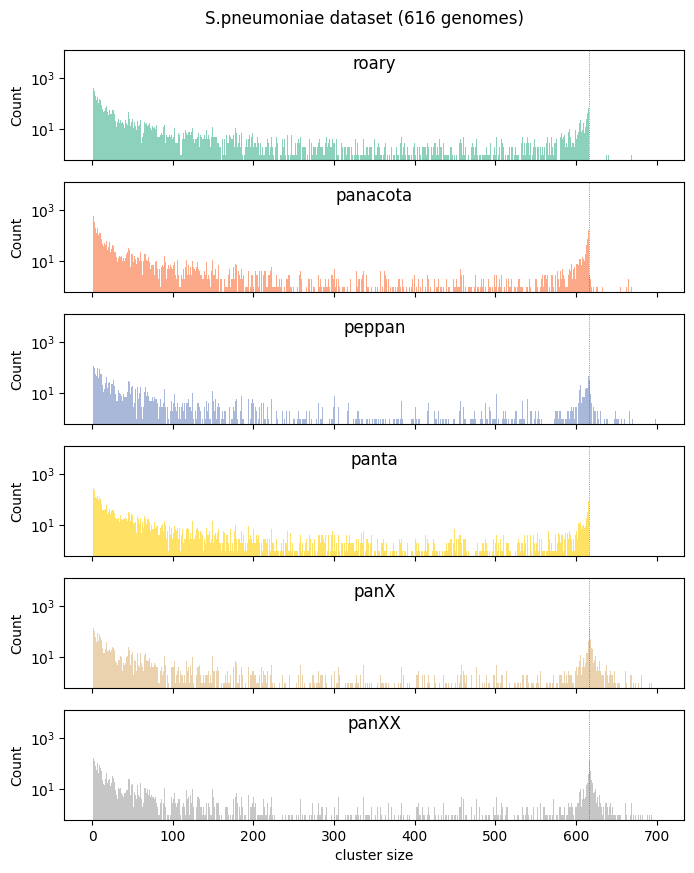

In [21]:
#------------------------------------------#
#        plot count distribution 
#         for Spneumo dataset
#------------------------------------------#

fig,axes = plt.subplots(ncols=1,nrows=len(METHODS),sharex=True,sharey=True,figsize=(8,10))

MAX=700
i=0
for method in METHODS:
    counts = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")["count"]
    #ignore clusters above n_genomes + 5
    c = counts[(counts>0)&(counts<=MAX)]
    ax = axes[i]
    sns.histplot(data=c,color=colors[method],edgecolor=None,ax=ax,discrete=True)
    ax.axvline(616,color="r",lw=.5,ls="dotted")
    ax.set_title(method,y=1.0,pad=-14)
    ax.set_yscale("log")
    ax.set_xlabel("cluster size")
    i+=1

fig.suptitle(f"S.pneumoniae dataset (616 genomes)",y=0.92)
# fig.tight_layout()

plt.show()

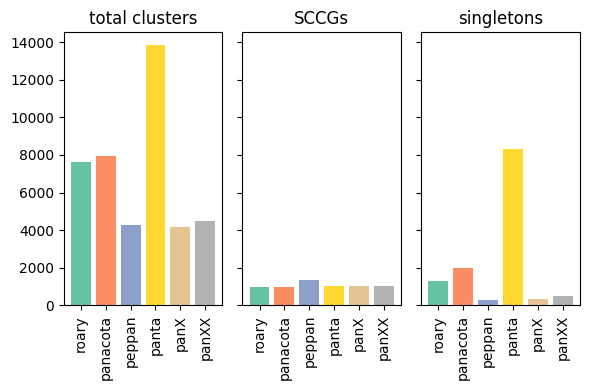

In [22]:
#------------------------------------------#
#          plot general numbers 
#          for Spneumo dataset
#------------------------------------------#

c = [colors[method] for method in METHODS]
data = pd.DataFrame()

for method in METHODS:
    df = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")
    sing = len(df[df["singleton"]=="yes"])
    sccg = len(df[df["sccg"]=="yes"])
    total = len(df)
    data[method] = [total,sccg,sing]

data = data.T.rename(columns={0:"total clusters",1:"sccg",2:"singleton"})

fig,axes = plt.subplots(ncols=3,nrows=1,sharex=True,sharey=True,figsize=(6,4))

axes[0].bar(data.index,data["total clusters"],color=c)
axes[0].set_title("total clusters")
axes[0].tick_params(axis="x",labelrotation=90)

axes[1].bar(data.index,data["sccg"],color=c)
axes[1].set_title("SCCGs")
axes[1].tick_params(axis="x",labelrotation=90)

axes[2].bar(data.index,data["singleton"],color=c)
axes[2].set_title("singletons")
axes[2].tick_params(axis="x",labelrotation=90)

fig.tight_layout()
fig.savefig("spneumo-overview.png",dpi=300)
plt.show()


In [27]:
#-------------------------------------------#
#        collect data CC heatmap                
#-------------------------------------------#

out_df = pd.DataFrame(columns=["reference","method","concordance"])

#compute cluster hashes
print("compute cluster hashes")
locus_hash = {}
for method in METHODS:
    labels = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")[["geneId","locus"]].explode("locus")
    labels = labels.query("locus in @common_loci").groupby("geneId").agg(list)
    locus_hash[method] = set(labels["locus"].apply(get_hash))

#compute concordance
print("compute concordance score")
for ref in METHODS:
    print(f"reference: {ref}")
    for method in METHODS:
        c = len(locus_hash[ref].intersection(locus_hash[method]))/len(locus_hash[method])
        out_df.loc[len(out_df)]=[ref,method,c]
print("Done!")

compute cluster hashes
compute concordance score
reference: panX
reference: panXX
reference: panacota
reference: panta
reference: peppan
reference: roary
Done!


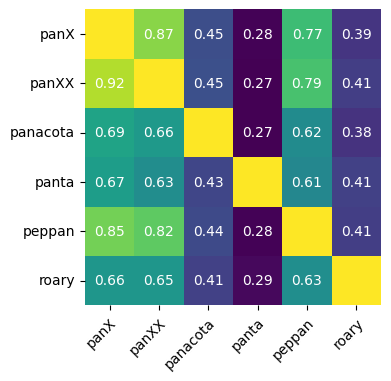

In [28]:
out_df = out_df.sort_values(by=["reference","method"],ascending=True)

concordance=out_df.concordance.to_numpy().reshape(6,6)
METHODS.sort()

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(concordance, xticklabels=METHODS,yticklabels=METHODS,cbar=False,cmap="viridis",ax=ax)

# Loop over data dimensions and create text annotations.
for i in range(6):
    for j in range(6):
        if i!=j:
            ax.text(j+0.5, i+0.5, "%0.2f" % (concordance[i, j]),horizontalalignment="center",verticalalignment="center",color="w")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_aspect(1)
fig.tight_layout()
fig.savefig("spneumo-cc.png",dpi=300)

plt.show()

In [25]:
#-------------------------------------------#
#        collect data ARI heatmap                
#-------------------------------------------#

out_df = pd.DataFrame(columns=["reference","method","ARI"])

for ref_method in METHODS:
    print(f"reference: {ref_method}")
    ref_labels = pd.read_json(f"bench-{organism}/{dataset}-{ref_method}.json")[["geneId","locus"]].explode("locus",ignore_index=True).sort_values("locus").reset_index(drop="index")
    for method in METHODS:
        if ref_method!=method:
            method_labels = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")[["geneId","locus"]].explode("locus",ignore_index=True)
            df = pd.merge(left=ref_labels,right=method_labels,how="inner",on="locus",suffixes=["_r","_m"])
            ARI=adjusted_rand_score(df["geneId_r"],df["geneId_m"])
            out_df.loc[len(out_df)]=[ref_method,method,ARI]
        else:
            out_df.loc[len(out_df)]=[ref_method,method,0]
print("Done!")

reference: panX
reference: panXX
reference: panacota
reference: panta
reference: peppan
reference: roary
Done!


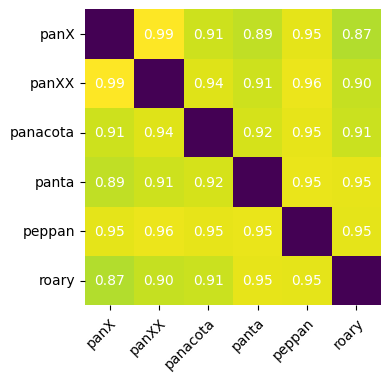

In [26]:
out_df = out_df.sort_values(by=["reference","method"],ascending=True)

ari=out_df.ARI.to_numpy().reshape(6,6)
METHODS.sort()

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(ari, xticklabels=METHODS,yticklabels=METHODS,cbar=False,cmap="viridis",ax=ax)

# Loop over data dimensions and create text annotations.
for i in range(6):
    for j in range(6):
        if i!=j:
            ax.text(j+0.5, i+0.5, "%0.2f" % (ari[i, j]),horizontalalignment="center",verticalalignment="center",color="w")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_aspect(1)
fig.tight_layout()
fig.savefig("spneumo-ari.png",dpi=300)

plt.show()